## What I Do

1. 基于ID3算法实现决策树
2. 将决策树用于海洋动物分类、预测隐形眼镜类型
3. 基于Sklearn实现决策树，进行验证

## 实验介绍

### 1.实验内容

本实验包括: 
* 学习并实现决策树算法----以ID3算法为例
* 基于决策树算法预测隐形眼镜类型

### 2.实验目标

通过本实验掌握决策树算法的基本原理。

### 3.实验知识点

* 香农熵
* 信息增益
* 决策树算法基本原理

### 4.实验环境

* python 3.6.5
* numpy 1.13.3
* matplotlib 2.2.3

### 实验准备

点击屏幕右上方的下载实验数据模块，选择下载decision_tree_glass.tgz到指定目录下，然后再依次选择点击上方的File->Open->Upload,上传刚才下载的数据集压缩包，再使用如下命令解压：

In [1]:
# !tar -zxvf ./work/decision_tree_glass.tgz

## 【海洋动物分类】

## 实验步骤：【海洋动物分类】- 概述

下表数据包含5个海洋动物，特征包括：不浮出水面是否可以生存，以及是否有脚蹼。我们将这些动物分成两类：鱼类和非鱼类。本实验要求基于决策树算法（ID3）实现对下表数据的分类。

id| 不浮出水面是否可以生存 | 是否有脚蹼 | 属于鱼类
:-: | :-: | :-:|:-:
1 | 是 | 是 | 是
2 | 是 | 是 | 是
3 | 是 | 否 | 否
4 | 否 | 是 | 否
5 | 否 | 是 | 否

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import operator

## 实验步骤：【海洋动物分类】- 创建数据集

基于上述表格，创建数据集。

In [3]:
def createDataSet():
    """
    函数说明：创建数据集
    returns:
        dataSet - 数据集
        labels - 分类属性
    """
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    return dataSet, labels

## 实验步骤：【海洋动物分类】- 计算香农熵

**香农熵**

$$
H=-\sum_{i=1}^np(x_i)\log_2{p(x_i)}
$$

In [4]:
def calcShannonEnt(dataSet):
    """
    函数说明:计算给定数据集的香农熵
    parameters:
        dataSet - 数据集
    returns:
        shannonEnt - 香农熵
    """
    num = len(dataSet)
    labelCounts = {}
    for featVac in dataSet:
        label = featVac[-1]
        if label not in labelCounts.keys():
            labelCounts[label] = 0
        labelCounts[label] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/num
        shannonEnt -= prob*math.log(prob, 20)
    return shannonEnt

## 实验步骤：【海洋动物分类】- 特征选择(基于信息增益划分数据集)

信息增益是相对于特征而言的，信息增益越大，特征对最终的分类结果影响也就越大，我们就应该选择对最终分类结果影响最大的那个特征作为我们的分类特征。

splitDataSet函数是用来选择各个特征的子集的。chooseBestFeatureToSplit函数是选择选择最优特征的函数。

In [5]:
def splitDataSet(dataSet, axis, value):
    """
    函数说明: 按照给定特征划分数据集
    parameters:
        dataSet - 待划分的数据集
        axis - 划分数据集的特征 (第axis个特征)
        value - 特征值
    returns:
        retDataSet - 划分后的数据集
    """
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

def chooseBestFeatureToSplit(dataSet):
    """
    函数说明: 选择最优特征
    parameters:
        dataSet - 数据集
    returns:
        bestFeature - 信息增益最大的(最优)特征的索引值
    """
    num = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(num):
        featureList = [x[i] for x in dataSet]
        uniqueVals = set(featureList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob*calcShannonEnt(subDataSet)
        infoGain = baseEntropy-newEntropy
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature 

## 实验步骤：【海洋动物分类】- 构建决策树

决策树构建算法流程：得到原始数据集，基于最好的属性值划分数据集。第一次划分之后，数据将被向下传递到树分支的下一个节点，在这个节点上，再次划分数据。采用递归的原则处理数据集。

递归结束条件：程序遍历完所有划分数据集的属性，或者每个分支下的所有实例都具有相同的分类。

In [6]:
def majorityCnt(classList):
    """
    函数说明:统计classList中出现此处最多的元素(类标签)
    Parameters:
        classList - 类标签列表
    Returns:
        sortedClassCount[0][0] - 出现此处最多的元素(类标签)
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels):
    """
    函数说明:创建决策树
    Parameters:
        dataSet - 训练数据集
        labels - 分类属性标签
    Returns:
        myTree - 决策树
    """
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1 or len(labels) == 0:
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)

    return myTree

## 实验步骤：【海洋动物分类】- 使用决策树进行分类

In [7]:
def classify(inputTree, featLabels, testVec):
    """
    函数说明:使用决策树分类
    Parameters:
        inputTree - 已经生成的决策树
        featLabels - 存储选择的最优特征标签
        testVec - 测试数据列表，顺序对应最优特征标签
    Returns:
        classLabel - 分类结果
    """
    firstStr = next(iter(inputTree))
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else: classLabel = secondDict[key]
    return classLabel

## 实验步骤：【海洋动物分类】- 创建可视化树形图

In [8]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    """
    函数说明:绘制结点
    Parameters:
        nodeTxt - 结点名
        centerPt - 文本位置
        parentPt - 标注的箭头位置
        nodeType - 结点格式
    Returns:
        无
    """
    arrow_args = dict(arrowstyle="<-")
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords = 'axes fraction',
                            va = 'center', ha = 'center', bbox = nodeType, arrowprops = arrow_args)

def createPlot(inTree):
    """
    函数说明:创建绘制面板
    Parameters:
        inTree - 决策树(字典)
    Returns:
        无
    """
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()


def getNumLeafs(myTree):
    """
    函数说明:获取决策树叶子结点的数目
    Parameters:
        myTree - 决策树
    Returns:
        numLeafs - 决策树的叶子结点的数目
    """
    numLeafs = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs
    

def getTreeDepth(myTree):
    """
    函数说明:获取决策树的层数
    Parameters:
        myTree - 决策树
    Returns:
        maxDepth - 决策树的层数
    """
    maxDepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotMidText(cntrPt, parentPt, txtString):
    """
    函数说明:标注有向边属性值
    Parameters:
        cntrPt、parentPt - 用于计算标注位置
        txtString - 标注的内容
    Returns:
        无
    """
    xMid = (parentPt[0]-cntrPt[0])/2.0+cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0+cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotTree(myTree, parentPt, nodeTxt):
    """
    函数说明:绘制决策树
    Parameters:
        myTree - 决策树(字典)
        parentPt - 标注的内容
        nodeTxt - 结点名
    Returns:
        无
    """
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")
    leafNode = dict(boxstyle="round4", fc="0.8")
    numLeafs = getNumLeafs(myTree) 
    depth = getTreeDepth(myTree)
    firstStr = next(iter(myTree))
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

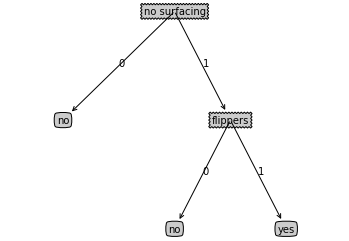

['no', 'yes']


In [9]:
if __name__ == '__main__':
    testVec1 = [1,0]
    testVec2 = [1,1]
    # 使用决策树对testVec1和testVec2分类
    myData, labels = createDataSet()
    myTree = createTree(myData, labels)
    createPlot(myTree)
    myData, labels = createDataSet()
    results = []
    results.append(classify(myTree, labels, testVec1))
    results.append(classify(myTree, labels, testVec2))
    print(results)

## 【预测隐形眼镜类型】

## 实验步骤：【预测隐形眼镜类型】- 概述

本实验要求基于决策树算法，帮助人们判断需要佩戴的镜片类型。

### 数据介绍
隐形眼镜数据集是非常著名的数据集，它包含很多换着眼部状态的观察条件以及医生推荐的隐形眼镜类型。隐形眼镜类型包括硬材质(hard)、软材质(soft)以及不适合佩戴隐形眼镜(no lenses)。

数据集一共有24组数据，数据的Labels依次是age、prescript、astigmatic、tearRate、class，也就是第一列是年龄，第二列是症状，第三列是是否散光，第四列是眼泪数量，第五列是最终的分类标签。

## 实验步骤：【预测隐形眼镜类型】- 创建决策树

编写代码，基于隐形眼镜数据集构造决策树，并输出。

In [10]:
fr = open('./work/decision_tree_glass/lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

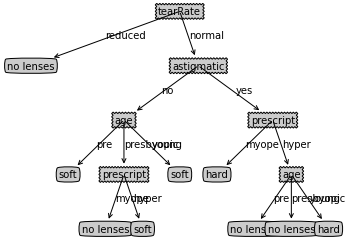

In [11]:
lensesTree = createTree(lenses, lensesLabels)
createPlot(lensesTree)

## 实验步骤：【预测隐形眼镜类型】- 基于Sklearn实现

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import tree
from six import StringIO
import pandas as pd
import numpy as np
import pydotplus

In [13]:
with open('./work/decision_tree_glass/lenses.txt', 'r') as fr:
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lenses_target = []
for each in lenses:
    lenses_target.append(each[-1])

In [14]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lenses_list = []
lenses_dict = {}
for each_label in lensesLabels:
    for each in lenses:
        lenses_list.append(each[lensesLabels.index(each_label)])
    lenses_dict[each_label] = lenses_list
    lenses_list = []

In [15]:
lenses_pd = pd.DataFrame(lenses_dict)
# print(lenses_pd)
le = LabelEncoder()
for col in lenses_pd.columns:
    lenses_pd[col] = le.fit_transform(lenses_pd[col])
# print(lenses_pd)

In [16]:
clf = tree.DecisionTreeClassifier(max_depth = 4)
clf = clf.fit(lenses_pd.values.tolist(), lenses_target)

In [17]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file = dot_data,
                     feature_names = lenses_pd.keys(),
                     class_names = clf.classes_,
                     filled=True, rounded=True,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("tree.pdf")
print(clf.predict([[1,1,1,0]]))

['hard']


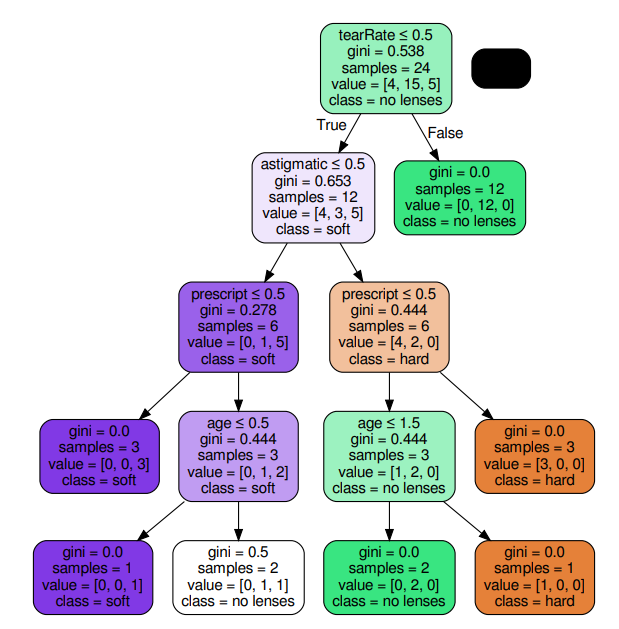